# Predicting Demand for Tech Jobs in Canada
#### CSCI 4050U – Final Project  
**Group Members:** Akshayan Balathas, Ryan Warrener, Ayaan Yousaf    
**Date:** December 8, 2025

--- 

## Introduction

In this project, we forecast labour demand for jobs in the Canadian technology sector (NAICS 54 - Professional, scientific, and technical services) using historical data from **Statistics Canada (StatCan)**. We use monthly data from the Job Vacancy and Wage Survey (JVWS) which provides data from 2015 to 2025. Using this data, we train an LSTM neural network to learn patterns and predict future demand for tech jobs in Canada.

Dataset: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410040601

## Loading the Dataset

In [138]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [139]:
# Load the data
df = pd.read_csv("data/target.csv", skiprows=7, nrows=5, header=1)
df

,North American Industry Classification System (NAICS) 3,Statistics,April 2015,May 2015,June 2015,July 2015,August 2015,September 2015,October 2015,November 2015,...,December 2024,January 2025,February 2025,March 2025,April 2025,May 2025,June 2025,July 2025,August 2025,September 2025
0,"Professional, scientific and technical service...",NaN,Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Job vacancies 4,F,"22,980","21,995","22,740","20,110","22,895","23,110","23,020",...,"36,465","35,225","37,925","39,520","37,785","35,990","35,575","38,035","36,245","36,960"
2,NaN,Payroll employees 5,"853,755","854,360","853,010","853,530","856,135","857,490","856,430","856,595",...,"1,228,150","1,231,235","1,228,460","1,230,025","1,229,120","1,230,770","1,232,470","1,229,445","1,234,300","1,233,005"
3,NaN,NaN,Percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Job vacancy rate 6,F,2.6,2.5,2.6,2.3,2.6,2.6,2.6,...,2.9,2.8,3.0,3.1,3.0,2.8,2.8,3.0,2.9,2.9


---

## Preprocessing and Cleaning
Before working with this data, we need to extract the information we need for our goal, and convert data into numerical values.

In [164]:
# Extract job vacancy rate row (target variable)
rate_row = df.iloc[4]

# Only keep monthly values
rate_values = rate_row[3:]

# Create job vacancies DataFrame
rate_df = pd.DataFrame({
    'Month': rate_values.index,
    'Job Vacancy Rate': rate_values.values
})

# Clean values and convert to numerical data (float)
rate_df['Job Vacancy Rate'] = (
    rate_df['Job Vacancy Rate']
    .astype(str)
    .str.replace(',', '')
    .str.extract(r"(\d+\.?\d*)")
    .astype(float)
)

# Format Month column and set as index
rate_df['Month'] = pd.to_datetime(rate_df['Month'], format='%B %Y')
rate_df = rate_df.sort_values('Month').set_index('Month')

# Handle NaN values using time-based linear interpolation
rate_df['Job Vacancy Rate'] = rate_df['Job Vacancy Rate'].interpolate(method='time')

# Display cleaned DataFrame
rate_df.head()


,Job Vacancy Rate
Month,
2015-05-01,2.6
2015-06-01,2.5
2015-07-01,2.6
2015-08-01,2.3
2015-09-01,2.6


---

## Exploratory Data Analysis (EDA)
Before building the LSTM model, we will visualize the historical trend of job vacancy rates in Canada's tech sector. Plotting the data will allow us to confirm that the data represents meaningful patterns and long-term trends. It is important we understand the trends before training our model, which will aim to predict the data for the future.

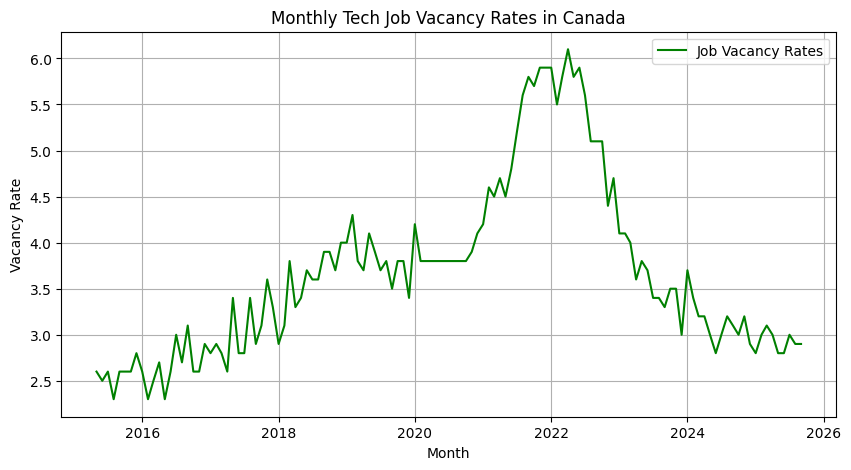

In [141]:
# Plot
plt.figure(figsize=(10, 5))

plt.plot(rate_df.index, rate_df['Job Vacancy Rate'], color='green', label='Job Vacancy Rates')
plt.title('Monthly Tech Job Vacancy Rates in Canada')

plt.xlabel('Month')
plt.ylabel('Vacancy Rate')

plt.grid(True)
plt.legend()
plt.show()

### Analysis
The visualization of tech job vacancy rates above shows a few clear patterns we can analyze: 

- **Upward Trend**: Overall, the data shows an upward trend in tech job demand, meaning there is increasingly more demand for tech jobs.
- **Post-COVID Spike**: The graph shows a massive surge in tech job vacancy rates following the COVID-19 pandemic. This suggests that demand for tech jobs was at an all-time high during this period, and slowly normalized to where it is at today. From 2021-2023, the demand for digital workers likely surged due to the effects of the pandemic.

After the surge in 2021-2023, the vacancy rates dropped significantly, going back to normal. These results reflect the constant need for workers in the tech industry.

---

## Build the LSTM Neural Network

### Scaling
Since our dataset is a time series and our learning problem requires an LSTM model, we need to scale the rate values to between 0 and 1. This is because LSTMs utilize activation functions (sigmoid/tanh), which require normalized values. Scaling our data will also prevent exploding or vanishing gradients. We can do this using MinMax scaling.

In [ ]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(rate_df[['Job Vacancy Rate']])

normalized_data[:8] # display first 8 normalized values

array([[0.07894737],
       [0.05263158],
       [0.07894737],
       [0.        ],
       [0.07894737],
       [0.07894737],
       [0.07894737],
       [0.13157895]])

### Creating Sequences
To train our model, we will create sequences which will serve as learning examples for the LSTM. We can do this by using a sliding window approach, where the model will analyze the input sequence (previous 12 months of values) and use those to predict the value for next month. 

In [143]:
# Function to create sequences, sliding window
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12
X, y = create_sequences(normalized_data, SEQ_LENGTH)

### PyTorch Dataset and DataLoader
Now, we can wrap our sequences and targets into a Dataset object. This will allow PyTorch's `DataLoader` to iterate over the data in batches for training.

In [144]:
# Custom Dataset class
class JobVacancyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Train/Test Split and DataLoaders
We split the dataset into training and testing parts. This will ensure that the model will be tested on data it has not seen before. In this case, we will use an 80/20 split for training/testing. Then we will wrap our data in `Dataset` and `DataLoader` objects so the model can perform batch training.

In [145]:
# Set number of training samples
train_size = len(X) - 12

# Split data into train and test
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Create datasets and dataloaders
train_dataset = JobVacancyDataset(X_train, y_train)
test_dataset = JobVacancyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### LSTM Model Architecture
We will use a simple Long Short-Term Memory (LSTM) model architecture to achieve our goal. 

The architecture includes: 
- One LSTM layer with a hidden size of 50
- One fully-connected (FC) Linear layer that produces an output using the final hidden state
- Hidden states and cell states initialized to 0 at each forward pass

In [146]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden state & cell state with 0s
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

### Initialize Model
With our LSTM model class created, we can create an instance of the model and do a quick test.

In [147]:
# Initialize model
model = LSTMForecaster(input_size=1, hidden_size=50, num_layers=1)

# Test with sample
sample_input, sample_target = next(iter(train_loader))
sample_output = model(sample_input)

print(f"Input Shape: {sample_input.shape}")
print(f"Output Shape: {sample_output.shape}")

Input Shape: torch.Size([16, 12, 1])
Output Shape: torch.Size([16, 1])


---

## Training the Model
During training, the model will learn how to predict vacancy rates for future months by learning patterns using the given set of training data. For each batch, it will produce an output, compare it with the expected output using MSE loss, then update its parameters through backpropagation. Over the number of epochs, the model will gradually minimize the loss and improve its ability to predict future demand.

### Training Loop

In [148]:
# Define MSE loss function and Adam optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100 # set epochs
model.train() # set model to train mode

# Begin training loop
print("Starting Training...")
for epoch in range(num_epochs):
    epoch_loss = 0
    
    for features, targets in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() # compute loss

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Starting Training...
Epoch [10/100], Loss: 0.0337
Epoch [20/100], Loss: 0.0178
Epoch [30/100], Loss: 0.0142
Epoch [40/100], Loss: 0.0078
Epoch [50/100], Loss: 0.0053
Epoch [60/100], Loss: 0.0089
Epoch [70/100], Loss: 0.0050
Epoch [80/100], Loss: 0.0049
Epoch [90/100], Loss: 0.0049
Epoch [100/100], Loss: 0.0048


---

## Evaluating the Model

### Evaluating Model on Test Set
The model will be evaluated on a set of data it has not seen before from our split earlier. This way, we can test how accurate the model is at making predictions and compute metrics to support it.

In [149]:
# Evaluate model on test set
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval() # set model to evaluation mode

all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        all_test_predictions.extend(outputs.cpu().numpy().flatten())
        all_test_targets.extend(targets.cpu().numpy().flatten())

# Convert to numpy arrays
all_test_predictions = np.array(all_test_predictions).reshape(-1, 1)
all_test_targets = np.array(all_test_targets).reshape(-1, 1)

# Inverse transform to original scale
predictions_test_actual = scaler.inverse_transform(all_test_predictions)
targets_test_actual = scaler.inverse_transform(all_test_targets)

# Calculate metrics
mae = mean_absolute_error(targets_test_actual, predictions_test_actual)
rmse = np.sqrt(mean_squared_error(targets_test_actual, predictions_test_actual))

print(f"\nTest Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Test Set Evaluation:
Mean Absolute Error (MAE): 0.1173
Root Mean Squared Error (RMSE): 0.1437


### Estimating Model Accuracy
On each run, the model seems to produce MAE and RMSE values which are very similar. For one specific run, we can estimate how accurate the model is by doing a simple calculation.

In [167]:
# Calculate model accuracy - Accuracy = 100 - (MAE / mean of actual values) * 100
mean_actual = np.mean(targets_test_actual)
accuracy = 100 - (mae / mean_actual) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 96.03%


### Visualizing Predictions

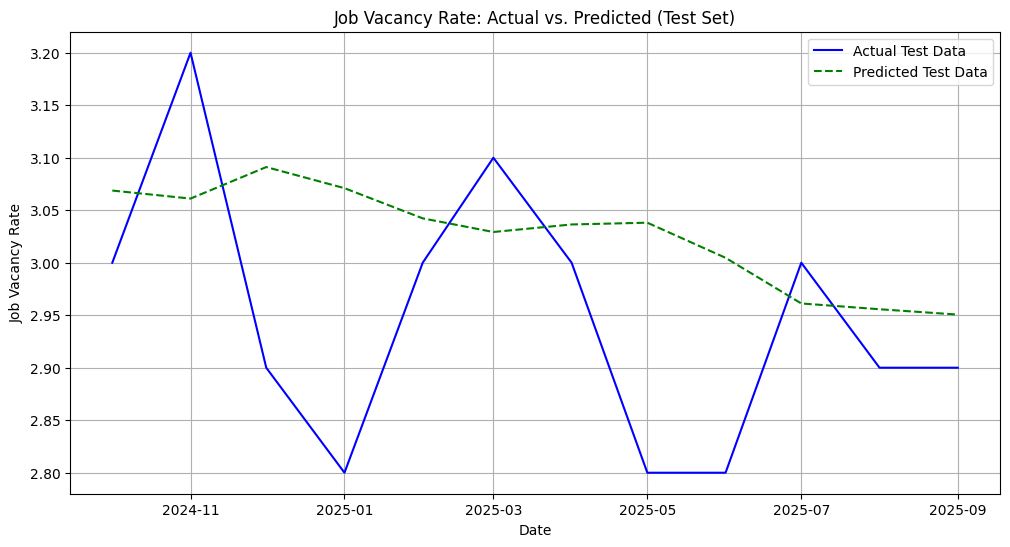

In [150]:
test_dates = rate_df.index[len(rate_df) - len(predictions_test_actual):]

# Plot test set predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates, targets_test_actual, label='Actual Test Data', color='blue')
plt.plot(test_dates, predictions_test_actual, label='Predicted Test Data', color='green', linestyle='--')

plt.title('Job Vacancy Rate: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Job Vacancy Rate')
plt.legend()
plt.grid(True)
plt.show()

---

## Forecasting
In this final section, we use our trained LSTM model to generate forward predictions for job vacancy rates in 2026. The model is fed previous monthly rates and any previous predictions as input. This allows it to produce an accurate estimate for next month's vacancy rates. It repeats this process for the number of months we want to forecast.

### Forecast Demand for Next Year (2026)

In [151]:
model.eval() # set model to evaluate mode

future_steps = 15 # number of months to forecast
predictions = [] # stores predicted values

current_sequence = torch.tensor(normalized_data[-SEQ_LENGTH:], dtype=torch.float32).unsqueeze(0)

# Begin forecasting
print("Forecasting future months...")
with torch.no_grad():
    for _ in range(future_steps):
        # predict the next step
        prediction = model(current_sequence)

        # save prediction (normalized)
        predictions.append(prediction.item())

        # update the sequence:
        new_step = prediction.unsqueeze(1)
        current_sequence = torch.cat((current_sequence[:, 1:, :], new_step), dim=1)

print("Forecasting complete.")

Forecasting future months...
Forecasting complete.


### Visualizing Forecast
A visualization of the actual data and the predicted rates will show us how the model's predictions fit in more clearly.

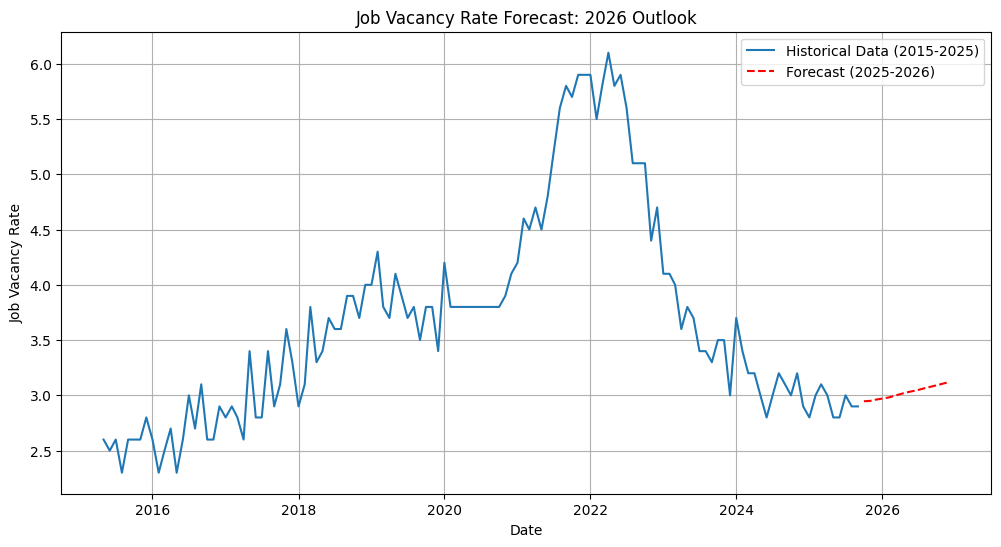


Predicted Job Market for 2026:
            Forecast
2026-01-01  2.970849
2026-02-01  2.980263
2026-03-01  2.994566
2026-04-01  3.011110
2026-05-01  3.026033
2026-06-01  3.037626
2026-07-01  3.049361
2026-08-01  3.064754
2026-09-01  3.078261
2026-10-01  3.091721
2026-11-01  3.105976
2026-12-01  3.120210


In [152]:
predictions_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Generate the future dates
last_date = rate_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Create a dataframe for the forecast
forecast_df = pd.DataFrame(predictions_actual, index=future_dates, columns=['Forecast'])

plt.figure(figsize=(12, 6))
plt.plot(rate_df.index, rate_df['Job Vacancy Rate'], label='Historical Data (2015-2025)')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (2025-2026)', color='red', linestyle='--')

plt.title('Job Vacancy Rate Forecast: 2026 Outlook')
plt.xlabel('Date')
plt.ylabel('Job Vacancy Rate')
plt.legend()
plt.grid(True)
plt.show()

print("\nPredicted Job Market for 2026:")
print(forecast_df[forecast_df.index.year == 2026])

---

## Conclusion

In this project, we developed an LSTM neural network to forecast labour demand in the Canadian technology sector using the Job Vacancy Rate
(NAICS 54) obtained from Statistics Canada. Our goal was to understand where the job market for technology in Canada is headed, and showcase how neural networks can be applied to real-world problems. 

After preprocessing the data, performing EDA, training, and evaluating the model, our results showed that the model was able to learn historical patterns in the vacancy rate and produce predictions with 96% accuracy on average. The evaluation metrics (MAE and RMSE) indicated that the model performs well with data it has not seen before. The 2026 forecast shows an upward trend in job vacancy rates and increasing demand for workers in tech.

Overall, this project shows how effective neural networks are at learning complex patterns for real-world problems. Specifically, it highlights the effectiveness of implementing LSTM architecture for solving problems with sequential data. 